In [3]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import division, print_function


import theano
import theano.tensor as T
import lasagne

import time
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from logs import log_fname, new_logger
from nn.rgl import ReverseGradientLayer
from nn.block import Dense, Classifier, adversarial
from nn.compilers import crossentropy_sgd_mom, squared_error_sgd_mom
from nn.training import Trainner, training

from utils import plot_bound, save_confusion_matrix
from sklearn.metrics import confusion_matrix

In [4]:
%matplotlib inline

# Load datasets

Here the datasets are loaded/built.

Function to make the *corrector* dataset.

## Clouds

In [5]:
from datasets.toys import load_clouds
n_samples = 30  # Number of sample per class
n_classes = 10
batchsize = 80

source_data = load_clouds(n_samples=n_samples, n_classes=n_classes, batchsize=batchsize)

### Clouds rotated

In [6]:
from datasets.utils import make_domain_dataset, make_corrector_dataset
from datasets.transform import rotate_dataset

data_name = 'Clouds_Rotated'
angle = 80

target_data = rotate_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

### Clouds . Random Matrix

In [ ]:
from datasets.utils import make_domain_dataset
from datasets.transform import random_mat_dataset

data_name = 'Clouds_RMat'

target_data = random_mat_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

## Moon


In [ ]:
from datasets.toys import load_moons
n_samples = 800
batchsize = 80

source_data = load_moons(n_samples=n_samples, batchsize=batchsize)

### Moon rotated

In [ ]:
from datasets.utils import make_domain_dataset
from datasets.transform import rotate_dataset

data_name = 'Moon_Rotated'
angle = 30.

target_data = rotate_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

### Moon . Random Matrix

In [ ]:
from datasets.utils import make_domain_dataset
from datasets.transform import random_mat_dataset

data_name = 'Moon_RMat'

target_data = random_mat_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

## MNIST

In [ ]:
from datasets.mnist import load_mnist
batchsize = 500
source_data = load_mnist(batchsize=batchsize)

### MNIST . Diag Dominant matrix

In [ ]:
from datasets.transform import diag_dataset

data_name = 'MNIST_Diag'

target_data = diag_dataset(source_data, normalize=True)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

### MNIST Mirror

In [ ]:
from datasets.transform import mirror_dataset

data_name = 'MNIST_Mirror'

target_data = mirror_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

### MNIST . Random Matrix

In [ ]:
from datasets.transform import random_mat_dataset

data_name = 'MNIST_Rmat'

target_data = random_mat_dataset(source_data)
domain_data = make_domain_dataset([source_data, target_data])
corrector_data = make_corrector_dataset(source_data, target_data)

## Epoch Preprocessing

The preprocessing function that will run at the begining of each epoch

In [7]:
# http://stackoverflow.com/questions/25886374/pdist-for-theano-tensor
# Tested and approved
X = T.fmatrix('X')
Y = T.fmatrix('Y')
translation_vectors = X.reshape((X.shape[0], 1, -1)) - Y.reshape((1, Y.shape[0], -1))
euclidiean_distances = (translation_vectors ** 2).sum(2)
f_euclidean = theano.function([X, Y], euclidiean_distances, allow_input_downcast=True)

In [8]:
def kclosest(X, Y, k, batchsize=None):
    """
    Computes for each sample from X the k-closest samples in Y and return 
    their index.

    Params
    ------
        X: (numpy array [n_sample, n_feature])
        Y: (numpy array [n_sample, n_feature])
        k: (int)
    Return
    ------
        kclosest : (numpy array [n_sample, k]) the ordered index of 
            the k-closest instances from Y to X samples
    """
    assert X.shape == Y.shape
    N = X.shape[0]
    if batchsize is None:
        dist = f_euclidean(X.reshape(N, -1), Y.reshape(N, -1))
    else:
        dist = np.empty((N, N), dtype=theano.config.floatX)
        batch = np.arange(0, N+batchsize, batchsize)
        for excerpt_X in (slice(i0, i1) for i0, i1 in zip(batch[:-1], batch[1:])):
            dist[excerpt_X] = f_euclidean(X[excerpt_X], Y)
    kbest = np.argsort(dist, axis=1)[:, :k]
    return kbest

In [9]:
def realign(X_out, X_trg, y, k=20, batchsize=None):
    counter = np.zeros(X_out.shape[0], dtype=int)
    idx = np.empty_like(y, dtype=int)
    for label in np.unique(y):
        # Get the examples of the right label
        idx_label = np.where(y==label)[0]

        # Get the k-closest index from the small part with the same labels
        idx_label2 = kclosest(X_out[idx_label], X_trg[idx_label], k, batchsize=batchsize)
        
        for i1, i2 in zip(idx_label, idx_label2):
            # i2 is an index array of shape (k,) with the sorted closest example index 
            # (of the sorted single class array)
            # Then idx_label[i2] are the sorted original index of the k-closest examples
            i = idx_label[i2[np.argmin(counter[idx_label[i2]])]]
            # i contains the chosen one, in the (k-)clostest example, with the minimum counter
            counter[i] = counter[i]+1
            idx[i1] = i
    return idx

In [10]:
def batchpad(batchsize, output_shape, dtype=None):
    """Re-batching decorator
    """
    def decoreted(func):
        def wrapper(X, *args, **kwargs):
            if dtype is None:
                dtype2 = X.dtype
            else:
                dtype2 = dtype
            
            N = X.shape[0]
            
            if output_shape is None:
                shape = X.shape
            else:
                shape = tuple( out_s if out_s is not None else X_s 
                              for out_s, X_s in zip(output_shape, X.shape))

            result = np.empty(shape, dtype=dtype2)
            batch = np.arange(0, N, batchsize)
            for excerpt_X in (slice(i0, i1) for i0, i1 in zip(batch[:-1], batch[1:])):
                result[excerpt_X] = func(X[excerpt_X], *args, **kwargs)
            
            last_excerpt = slice(batch[-1], N)
            X = X[last_excerpt]
            n_sample = X.shape[0]
            X = np.vstack([X, np.zeros((batchsize-X.shape[0],)+X.shape[1:])])
            X = func(X, *args, **kwargs)
            result[last_excerpt] = X[:n_sample]
            
            return result
        return wrapper
    return decoreted

In [11]:
# Méthode bourin. K-clostest on every data point
def exhaustive_clostest(data, trainer, epoch, *args, **kwargs):
    X = data['X_train']
    k = data['k'] if 'k' in data else 5

    @batchpad(data['batchsize'], X.shape, X.dtype)
    def f_output(X, trainer):
        return trainer.output(X)[0]
    
    X_out = f_output(X, trainer)
    X_trg = data['y_train']
    data['X_train'] = X[realign(X_out, X_trg, data['labels'], k=k, batchsize=None)]
    return None

In [12]:
def classwise_shuffle(X, y):
    """
    Shuffle X without changing the class positions

    Params
    ------
        X: the data (numpy array)
        y: the labels 
    Return
    ------
        X_shuffled: Shuffled X without changing the class matching
    """
    idx = np.empty_like(y, dtype=int)
    for label in np.unique(y):
        arr = np.where(y==label)[0]
        arr2 = np.random.permutation(arr)
        idx[arr] = arr2
    return X[idx]


def epoch_shuffle(data, trainer, epoch, *args, **kwargs):
    data['X_train'] = classwise_shuffle(data['X_train'], data['labels'])
    return None


In [13]:
def cluster_preprocess(data, trainer, epoch, *args, **kwargs):
    k = data['k'] if 'k' in data else 5
    
    @batchpad(data['batchsize'], None, X.dtype)
    def f_output(X, trainer):
        return trainer.output(X)[0]
    
    idx = realign(f_output(data['X_train_centers'], trainer), data['y_train_centers'], 
                  data['centers_labels'], k=k, batchsize=None)
    # idx takes the indexes to relabel the closest clusters
    # [2, 0, 1, 3]  means  0<-2, 1<-0, 2<-1, 3<-3
    data['X_train_closest_cluster'] = idx[data['X_train_clusters'][:]]
    # Now data['X_train_closest_cluster'] contains the nearest clusters label
    # from each data in X_train to the clusters of y_train
    
    # Do a random realign from here
    data['X_train'] = classwise_shuffle(data['X_train'], data['X_train_closest_cluster'])
    
    # Or a fully k-closest realignment
    #idx = realign(f_output(data['X_train'], trainer), data['y_train'],
    #                            data['X_train_closest_cluster'], k=k, batchsize=None)
    #data['X_train'] = data['X_train'][idx]
    data['preprocess'] = idx
    return idx
    

# Build the Neural Network

## Network building
Start with the variables

## Parameters

In [14]:
hp_lambda = 0.

label_rate = 1
label_mom = 0.9

domain_rate = 1
domain_mom = 0.9

# Get a logger
logger = new_logger()


In [15]:
# Prepare Theano variables for inputs and targets
if data_name.startswith('MNIST'):
    input_var = T.tensor3('inputs')
    src_var = T.tensor3('src')
    target_var = T.tensor3('targets')
    shape = (batchsize, 28, 28)
elif data_name.startswith('Moon') or data_name.startswith('Clouds'):
    input_var = T.matrix('inputs')
    src_var = T.matrix('src')
    target_var = T.matrix('targets')
    shape = (batchsize, 2)

# Logs
logger.info('Building the input and output variables for |{}|'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))


[17:23:09] INFO    : Building the input and output variables for |Clouds_Rotated|
[17:23:09] INFO    : Input data expected shape : (80, 2)


## Architecture

In [16]:
# Build the layers
input_layer = lasagne.layers.InputLayer(shape=shape, input_var=input_var)
src_layer = lasagne.layers.InputLayer(shape=shape, input_var=src_var)
# feature = lasagne.layers.DenseLayer(
#                 input_layer,
#                 num_units=np.prod(shape[1:]),
#                 nonlinearity=lasagne.nonlinearities.tanh,
#                 # W=lasagne.init.Uniform(range=0.01, std=None, mean=0.0),
#                 )
feature = lasagne.layers.DenseLayer(
                input_layer,
                num_units=np.prod(shape[1:]),
                nonlinearity=None,
                # W=lasagne.init.Uniform(range=0.01, std=None, mean=0.0),
                )
reshaper = lasagne.layers.ReshapeLayer(feature, (-1,) + shape[1:])
output_layer = reshaper

# Logs
logger.info('Building the neural network architecture for |{}|'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))


/home/victor/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
[17:23:09] INFO    : Building the neural network architecture for |Clouds_Rotated|
[17:23:09] INFO    : Input data expected shape : (80, 2)


## Compiling 

In [17]:
# Logs
logger.info('Compiling the neural network for |{}|'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))

# Compilation
corrector_trainner = Trainner(squared_error_sgd_mom(output_layer, lr=label_rate, mom=0, target_var=target_var), 
                             'corrector',)

if hp_lambda != 0.0:
    print('hp_lambda != 0 : Compliling the adversarial part of the networks')
    domain_trainner = Trainner(adversarial([src_layer, output_layer], hp_lambda=hp_lambda,
                                          lr=domain_rate, mom=domain_mom),
                               'domain')


[17:23:09] INFO    : Compiling the neural network for |Clouds_Rotated|
[17:23:09] INFO    : Input data expected shape : (80, 2)
/home/victor/anaconda/lib/python2.7/site-packages/Lasagne-0.1.dev0-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


## Add preprocessing (for alignment)

In [18]:
from sklearn.cluster import KMeans

# Choose preprocessing :
#corrector_trainner.preprocess = epoch_shuffle
#corrector_trainner.preprocess = exhaustive_clostest
corrector_trainner.preprocess = cluster_preprocess

model_name = ''
if corrector_trainner.preprocess is epoch_shuffle:
    model_name = 'Classwise_Corrector'
    corrector_data['labels'] = source_data['y_train']
elif corrector_trainner.preprocess is exhaustive_clostest:
    model_name = 'K-closest_Corrector'
    corrector_data['labels'] = source_data['y_train']
elif corrector_trainner.preprocess is cluster_preprocess:
    model_name = 'Cluster_Corrector'
    n_clusters = 10
    corrector_data['k'] = 10
    y = source_data['y_train']
    classes = np.unique(y)

    centers = []
    clusters_label = np.empty(corrector_data['X_train'].shape[0], dtype=int)
    labels = []
    for label in classes:
        km = KMeans(n_clusters=n_clusters)
        y = source_data['y_train']
        idx = np.where(y==label)[0]
        X = corrector_data['X_train'][idx]
        km.fit(X.reshape((X.shape[0], -1)))
        centers.append(km.cluster_centers_.reshape((n_clusters,)+shape[1:]))
        clusters_label[idx] = km.labels_+label*n_clusters
        labels.append(np.ones(n_clusters, dtype=int)*label)
    
    corrector_data['X_train_centers'] = np.vstack(centers)
    corrector_data['X_train_clusters'] = clusters_label
    corrector_data['centers_labels'] = np.hstack(labels)
    
    centers = []
    labels = []
    clusters_label = np.empty(corrector_data['y_train'].shape[0], dtype=int)
    for label in classes:
        km = KMeans(n_clusters=n_clusters)
        y = target_data['y_train']
        idx = np.where(y==label)[0]
        X = corrector_data['y_train'][idx]
        km.fit(X.reshape((X.shape[0], -1)))
        centers.append(km.cluster_centers_.reshape((n_clusters,)+shape[1:]))
        clusters_label[idx] = km.labels_+label*n_clusters
    corrector_data['y_train_centers'] = np.vstack(centers)
    corrector_data['y_train_clusters'] = clusters_label

else:
    model_name = 'Pairwise_Corrector'


# Train the neural network

Reset the counter and the stats

In [19]:
logger.warn('Reset the epoch counter and saved statistics')
epoch_counter = 0
final_stats = {}


[17:23:11] WARNING : Reset the epoch counter and saved statistics


## Training loop 

In [20]:
def do_n_epoch(n_epoch):
    global epoch_counter, logger, final_stats
    global corrector_data, domain_data, corrector_trainner, domain_trainner
    epoch_counter += n_epoch
    logger.info('Trainning the neural network for {} additional epochs ({} total)'.format(n_epoch, epoch_counter))
    if hp_lambda != 0.0:
        stats = training([corrector_trainner, domain_trainner], [corrector_data, domain_data],
                         num_epochs=n_epoch, logger=logger)
    else:
        stats = training([corrector_trainner,], [corrector_data,],
                     num_epochs=n_epoch, logger=logger)

    final_stats = {k: (final_stats[k]+v if k in final_stats else v) for k, v in stats.items()}

# Plot results

## Learning curve


In [21]:
def plot_learning_curve():
    global final_stats, data_name, model_name, hp_lambda
    title = '++'.join([data_name, model_name, 'lambda={:.3e}'.format(hp_lambda)])
    # Plot learning accuracy curve
    fig, ax = plt.subplots()
    ax.plot(final_stats['corrector valid loss'], label='source')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #fig.savefig('fig/'+title+'.png', bbox_inches='tight')
    #fig.clf() # Clear plot window
    plt.show()

## 2D Data plot

In [22]:
def plot_2D_data(save=False):
    global data_name, model_name, hp_lambda
    title = '++'.join([data_name, model_name, 'lambda={:.3e}'.format(hp_lambda)])
    global source_data, target_data, corrector_data, corrector_trainner
    
    if data_name.startswith('MNIST'):
        return
    
    from matplotlib.colors import ListedColormap
    import matplotlib.cm as cm
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    if data_name.startswith('Moon'):
        color = cm.ScalarMappable(cmap=cm_bright)
    else:
        color = cm.ScalarMappable(cmap='Paired')

    if data_name.startswith('Moon') or data_name.startswith('Clouds'):
        # Plot the test data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        X = source_data['X_test']
        y = source_data['y_test']
        ax1.scatter(X[:, 0], X[:, 1], label='source', marker='o', s=80, edgecolors=color.to_rgba(y), facecolors='none')
        ax2.scatter(X[:, 0], X[:, 1], label='source', marker='o', s=80, edgecolors=color.to_rgba(y), facecolors='none')

        X = np.array(corrector_trainner.output(target_data['X_test'])).reshape((-1, 2))
        y = target_data['y_test']
        ax1.scatter(X[:, 0], X[:, 1], label='corrected', marker='x', s=80, edgecolors=color.to_rgba(y), facecolors=color.to_rgba(y))
    
        if 'X_train_centers' in corrector_data:
            X = corrector_data['X_train_centers']
            #ax1.scatter(X[:, 0], X[:, 1], label='target centers', marker='D', s=100, edgecolors='green', facecolors='green')
            ax2.scatter(X[:, 0], X[:, 1], label='target centers', marker='D', s=100, edgecolors='green', facecolors='green')
        
            X = np.array(corrector_trainner.output(corrector_data['X_train_centers'])).reshape((-1, 2))
            ax1.scatter(X[:, 0], X[:, 1], label='corrected centers', marker='D', s=100, edgecolors='k', facecolors='k')

        if 'y_train_centers' in corrector_data:
            X = corrector_data['y_train_centers']
            ax1.scatter(X[:, 0], X[:, 1], label='source centers', marker='D', s=100, edgecolors='purple', facecolors='purple')
            ax2.scatter(X[:, 0], X[:, 1], label='source centers', marker='D', s=100, edgecolors='purple', facecolors='purple')

        if 'preprocess' in corrector_data and 'X_train_centers' in corrector_data and 'y_train_centers' in corrector_data:
            idx = corrector_data['X_train_closest_cluster'][::10]
            centers_corrected = np.array(corrector_trainner.output(corrector_data['X_train'][::10])).reshape((-1, 2))
            centers_source = corrector_data['y_train_centers']
            centers_source = centers_source[idx]
            ax1.quiver(centers_corrected[:,0],centers_corrected[:,1],
                      centers_source[:,0]-centers_corrected[:,0], centers_source[:,1]-centers_corrected[:,1],
                      scale_units='xy', angles='xy', scale=1, facecolors='b', width=0.001)

            centers_corrected = np.array(corrector_trainner.output(corrector_data['X_train'][::8])).reshape((-1, 2))
            centers_source = corrector_data['y_train'][::8]
            ax1.quiver(centers_corrected[:,0],centers_corrected[:,1],
                      centers_source[:,0]-centers_corrected[:,0], centers_source[:,1]-centers_corrected[:,1],
                      scale_units='xy', angles='xy', scale=1, facecolors='r', width=0.001)

            idx = corrector_data['preprocess']
            centers_corrected = np.array(corrector_trainner.output(corrector_data['X_train_centers'])).reshape((-1, 2))
            centers_source = corrector_data['y_train_centers']
            centers_source = centers_source[idx]
            ax1.quiver(centers_corrected[:,0],centers_corrected[:,1],
                      centers_source[:,0]-centers_corrected[:,0], centers_source[:,1]-centers_corrected[:,1],
                      scale_units='xy', angles='xy', scale=1, facecolors='g')

        ax1.set_title(title)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        
        X = target_data['X_test']
        y = target_data['y_test']
        ax2.scatter(X[:, 0], X[:, 1], label='target', marker='x', s=80, edgecolors=color.to_rgba(y), facecolors=color.to_rgba(y))
        ax2.set_title(title)
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        if save:
            fig.savefig('../fig/'+title+'-corrected_data.png', bbox_inches='tight')
            #plt.tight_layout()
        plt.show()

        #logger.info('Data plot {}'.format(X.shape))


In [23]:
def plot_img_samples():
    global data_name, model_name, hp_lambda
    title = '++'.join([data_name, model_name, 'lambda={:.3e}'.format(hp_lambda)])
    global source_data, target_data, corrector_trainner
    
    if not data_name.startswith('MNIST'):
        return

    # Plot some sample images:
    fig = plt.figure()
    n_sample = 4
    rand = np.random.RandomState()
    for n in range(n_sample):
        i = rand.randint(source_data['X_test'].shape[0])
        sample_src = source_data['X_test'][i]
        sample_trg = target_data['X_test'][i]
        sample_corrected = corrector_trainner.output(target_data['X_test'][i][np.newaxis])
        sample_corrected = np.array(sample_corrected).reshape((28,28))
        ax = fig.add_subplot(n_sample, 3, n*3+1)
        ax.axis('off')
        ax.imshow(sample_src, cmap='Greys_r')
        ax.set_title('Source image')
        ax = fig.add_subplot(n_sample, 3, n*3+2)
        ax.axis('off')
        ax.imshow(sample_trg, cmap='Greys_r')
        ax.set_title('Target image')
        ax = fig.add_subplot(n_sample, 3, n*3+3)
        ax.axis('off')
        ax.imshow(sample_corrected, cmap='Greys_r')
        ax.set_title('Corrected image')
    fig.show()

In [45]:
def plot_W():
    global data_name, model_name, hp_lambda
    title = '++'.join([data_name, model_name, 'lambda={:.3e}'.format(hp_lambda)])
    global feature
    # Plot the weights of the corrector
    W = feature.W.get_value()
    sns.heatmap(W, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.show()

In [46]:
print(model_name, data_name)

Cluster_Corrector Clouds_Rotated


# Play !

[18:10:57] INFO    : Trainning the neural network for 1 additional epochs (8 total)
[18:10:57] INFO    : Starting training...
[18:10:57] INFO    : Epoch 1 of 1 took 0.014s
[18:10:57] INFO    :    corrector training acc         : 0.122865
[18:10:57] INFO    :    corrector training loss        : 0.001229
[18:10:57] INFO    :    corrector valid acc            : 0.001473
[18:10:57] INFO    :    corrector valid loss           : 0.000015


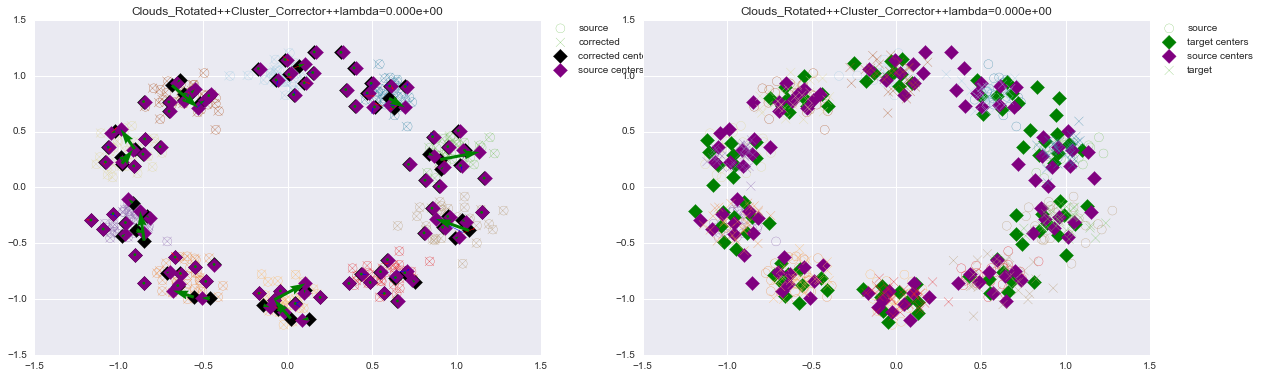

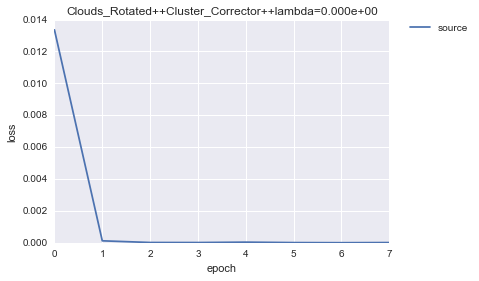

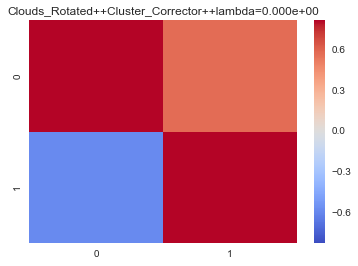

In [47]:
do_n_epoch(1)
plot_2D_data(save=True)
plot_img_samples()
plot_learning_curve()
plot_W()